In [35]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
from __future__ import print_function, absolute_import

import matplotlib.pyplot as plt

### 1) No-op

Step 1) Vanilla dircol traj. optimization.

In [3]:
from traj.dircol import make_real_dircol_mp

dircol, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = dircol.input()
dircol.AddRunningCost(R*u[0]**2)

Step 2) Simple supervised learning on (x, u) pairs, with no constraints on policy.

### 2) GPS

Step 1) dircol traj. optimization using Augmented Lagrangian

In [65]:
import numpy as np

from nn_system.NNSystemHelper import FC, MLP

from traj.dircol import (
    add_running_custom_cost_fn,
    make_pytorch_net_autodiffable,
    make_real_dircol_mp,
)


prog, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = prog.input()
prog.AddRunningCost(R*u[0]**2)

# Make an auto-differentiable pytorch net function
# net = None
# net = FC(4).double()
net = MLP(4).double()
Pi = make_pytorch_net_autodiffable(net)
lam_t, rho_t = 1, 1 # TODO: use actual lam and rho variables.

def lagrangian(x_t, u_t, t):
    cost = lam_t * (Pi(x_t) - u_t) \
         + rho_t * (Pi(x_t) - u_t).dot(Pi(x_t) - u_t)
    return cost

add_running_custom_cost_fn(prog, lagrangian)

Step 2) Supervised learning on (x, u) pairs, using Augmented Lagrangian

### 3) Interactive Control

Step 1) dircol traj. optimization with L2 augmentation and L2 trajectory distance penalty.

In [30]:
import numpy as np

from nn_system.NNSystemHelper import FC, MLP

from traj.dircol import (
    add_running_custom_cost_fn,
    make_pytorch_net_autodiffable,
    make_real_dircol_mp,
)


prog, tree = make_real_dircol_mp(expmt="cartpole", seed=1776)

R = 10  # Cost on input "effort".
u = prog.input()
prog.AddRunningCost(R*u[0]**2)

# Make an auto-differentiable pytorch net function
# net = None
# net = FC(4).double()
net = MLP(4).double()
Pi = make_pytorch_net_autodiffable(net)
alpha, gamma = 1, 1 # TODO: use actual variables, here.
x_ref = [0]*21 # TODO
def mycost(x_t, u_t, timestep):
    cost = alpha/2 * (Pi(x_t) - u_t).dot(Pi(x_t) - u_t)
         + gamma/2 * (x_t - x_ref[timestep]).dot(x_t - x_ref[timestep])
    return cost

add_running_custom_cost_fn(prog, mycost)

Step 2) Simple supervised learning on (x, u) pairs, with L2 augmentation and L2 policy distance penalty.

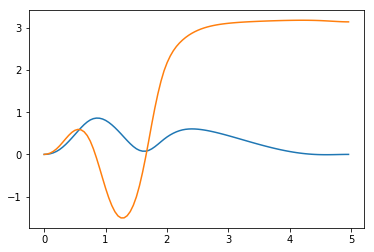

In [66]:
############################################################
# Run this cell to run the code!
############################################################

ret = prog.Solve()

x_trajectory = prog.ReconstructStateTrajectory()
breaks = np.linspace(x_trajectory.start_time(),x_trajectory.end_time(),100)
x_knots = np.hstack([x_trajectory.value(t) for t in breaks])

plt.plot(breaks, x_knots[0,:], breaks, x_knots[1,:])